# Lab | Handling Data Imbalance in Classification Models

## Instructions

Scenario
You are revisiting the Healthcare for All Case Study. You are provided with this historical data about Donors and how much they donated. Your task is to build a machine learning model that will help the company identify people who are more likely to donate and then try to predict the donation amount.

Instructions
In this lab, we will first take a look at the degree of imbalance in the data and correct it using the techniques we learned in the class.

Here is the list of steps to be followed (building a simple model without balancing the data):

- Import the required libraries and modules that you would need.
- Read that data into Python and call the dataframe donors.
- Check the datatypes of all the columns in the data.
- Check for null values in the dataframe. Replace the null values using the methods learned in class.
- Split the data into numerical and catagorical. Decide if any columns need their dtype changed.
- Concatenate numerical and categorical back together again for your X dataframe. Designate the Target as y.
    - Split the data into a training set and a test set.
    - Split further into train_num and train_cat. Also test_num and test_cat.
    - Scale the features either by using normalizer or a standard scaler. (train_num, test_num)
    - Encode the categorical features using One-Hot Encoding or Ordinal Encoding. (train_cat, test_cat)
        - fit only on train data transform both train and test
        - again re-concatenate train_num and train_cat as X_train as well as test_num and test_cat as X_test
    - Fit a logistic regression model on the training data.
    - Check the accuracy on the test data.
Note: So far we have not balanced the data.

Managing imbalance in the dataset

- Check for the imbalance.
- Use the resampling strategies used in class for upsampling and downsampling to create a balance between the two classes.
- Each time fit the model and see how the accuracy of the model has changed.

## Importing Libraries

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
pd.set_option('display.max_columns', None)

#train-test-split
from sklearn.model_selection import train_test_split

#categorical variables
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

#for regression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

## Functions: 
- to check for null values in all the columns
- to check the data types

In [297]:
#Function to check for NaNs:
def get_percentnan(dataframe):
    data_percentnan = pd.DataFrame((dataframe.isna().sum()/len(dataframe))*100)
    data_percentnan = data_percentnan.reset_index()
    data_percentnan.columns = ['column_name', 'nulls_percentage']
    data_percentnan = data_percentnan[(data_percentnan['nulls_percentage'] > 0)]
    
    return data_percentnan

In [298]:
#check the columns and the data types
def data_colandtype(dataframe):
    data_col = pd.DataFrame(dataframe.iloc[0 , :])
    data_col['type'] = dataframe.dtypes
    unique_values = []
    for column in dataframe.columns:
        unique_values.append(len(dataframe[column].unique()))
    data_col['#_unique_values'] = unique_values
    data_col = data_col.reset_index()
    data_col.columns = ['header_name', 'row_0', 'type','#_unique_values']
    pd.set_option('display.max_rows', None)
    display(data_col)
    return


In [299]:
#plot categorical countplots
def plot_categorical_countplot(categorical_df):
    for column in categorical_df.columns:
        plt.figure(figsize=(5, 5))
        
        ax = sns.countplot(x=column, data=categorical_df)
        #ax = sns.histplot(data=categorical_df, x=column, stat="percent")#, multiple="dodge", shrink=.8)

        #rotating the ticklabels on the x-asis:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
        plt.tight_layout()
        plt.show()

## Get data

In [300]:
numerical = pd.read_csv('numerical.csv')
categorical = pd.read_csv('categorical.csv')
target = pd.read_csv('target.csv')

## Cleaning/Wrangling/EDA

In [301]:
# From past labs and lessons we know that some
# column looks more categorical than numerical.
numerical['INCOME'] = numerical['INCOME'].astype('object')
numerical['WEALTH1'] = numerical['WEALTH1'].astype('object')
numerical['WEALTH2'] = numerical['WEALTH2'].astype('object')
numerical['HPHONE_D'] = numerical['HPHONE_D'].astype('object')
numerical['RFA_2F'] = numerical['RFA_2F'].astype('object')


In [302]:

categorical = pd.concat([categorical, numerical['INCOME'],numerical['WEALTH1'],numerical['WEALTH2'],numerical['HPHONE_D'],numerical['RFA_2F']], axis = 1)
categorical.head()

,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,INCOME,WEALTH1,WEALTH2,HPHONE_D,RFA_2F
0,IL,36,H,F,3,L,E,C,T,2,89,1,37,12,92,8,94,2,95,12,89,11.0,5,9,5,0,4
1,CA,14,H,M,3,L,G,A,S,1,94,1,52,2,93,10,95,12,95,12,93,10.0,6,9,9,0,2
2,NC,43,U,M,3,L,E,C,R,2,90,1,0,2,91,11,92,7,95,12,90,1.0,3,1,1,1,4
3,CA,44,U,F,3,L,E,C,R,2,87,1,28,1,87,11,94,11,95,12,87,2.0,1,4,0,1,4
4,FL,16,H,F,3,L,F,A,S,2,86,1,20,1,93,10,96,1,96,1,79,3.0,3,2,9,1,2


In [303]:
numerical = numerical.drop(columns=['INCOME', 'WEALTH1', 'WEALTH2', 'HPHONE_D', 'RFA_2F'], axis=1)
numerical.shape 
# we lost 5 columns so fine.

(95412, 310)

### Categorical Columns:

We will work with the categorical features first. Look at the columns one by one. Some of the operations which we will perform are:

- Replace null values with the most occurring categories
- Reduce the number of categories in a column by grouping

It is important to note that some columns are defined by python as categorical/object types. There might be other columns defined as numerical that we want as categorical. We will look them later when we were working on numerical types.

In [304]:
print(categorical.shape)
categorical.head()

(95412, 27)


,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,INCOME,WEALTH1,WEALTH2,HPHONE_D,RFA_2F
0,IL,36,H,F,3,L,E,C,T,2,89,1,37,12,92,8,94,2,95,12,89,11.0,5,9,5,0,4
1,CA,14,H,M,3,L,G,A,S,1,94,1,52,2,93,10,95,12,95,12,93,10.0,6,9,9,0,2
2,NC,43,U,M,3,L,E,C,R,2,90,1,0,2,91,11,92,7,95,12,90,1.0,3,1,1,1,4
3,CA,44,U,F,3,L,E,C,R,2,87,1,28,1,87,11,94,11,95,12,87,2.0,1,4,0,1,4
4,FL,16,H,F,3,L,F,A,S,2,86,1,20,1,93,10,96,1,96,1,79,3.0,3,2,9,1,2


In [305]:
get_percentnan(categorical)
# We might have to look at the NaNs in the "FIRSTDATE_MM"-column

,column_name,nulls_percentage
21,FIRSTDATE_MM,0.002096


In [306]:
data_colandtype(categorical)

,header_name,row_0,type,#_unique_values
0,STATE,IL,object,12
1,CLUSTER,36,int64,53
2,HOMEOWNR,H,object,2
3,GENDER,F,object,3
4,DATASRCE,3,int64,3
5,RFA_2R,L,object,1
6,RFA_2A,E,object,4
7,GEOCODE2,C,object,4
8,DOMAIN_A,T,object,5
9,DOMAIN_B,2,int64,4


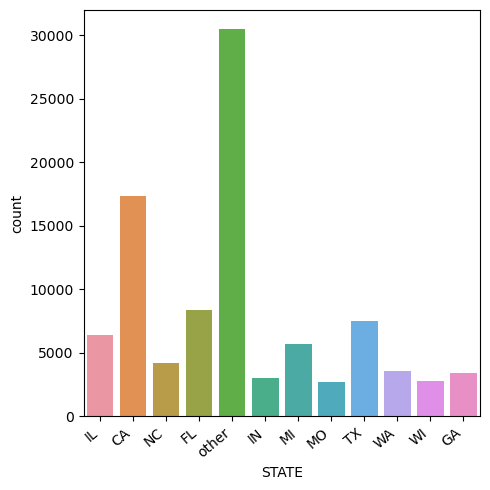

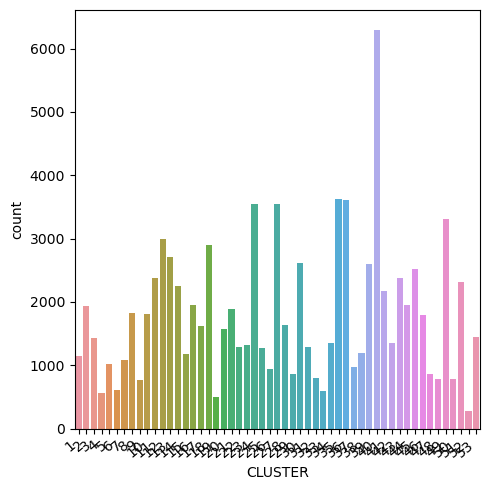

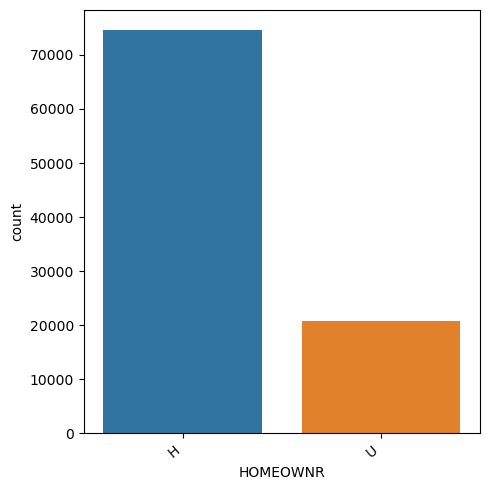

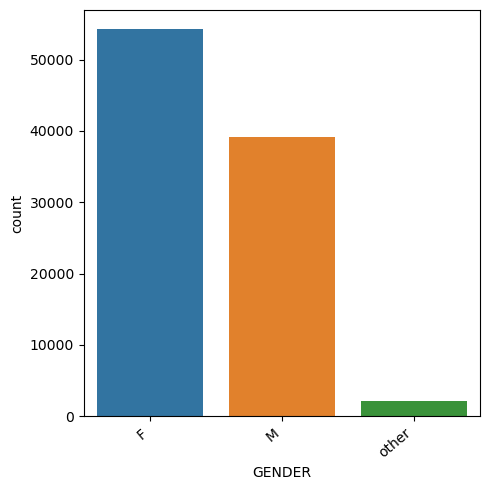

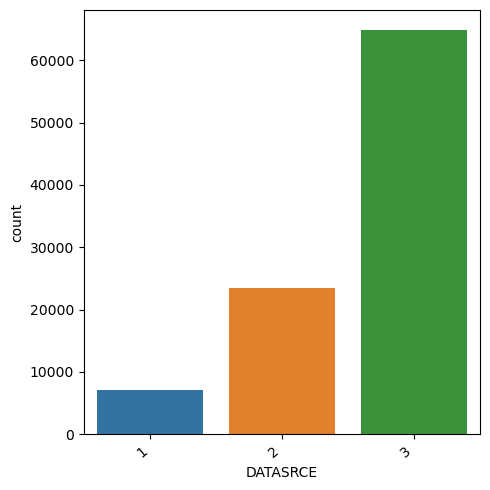

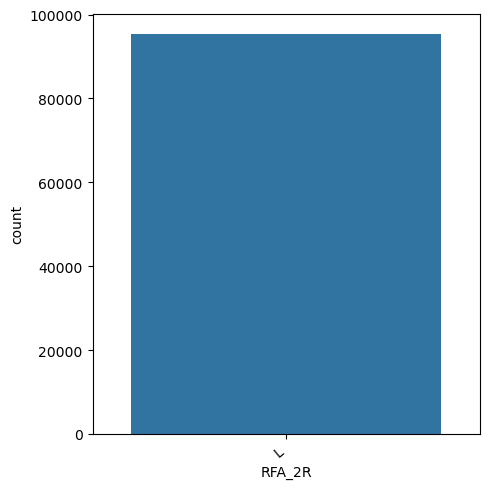

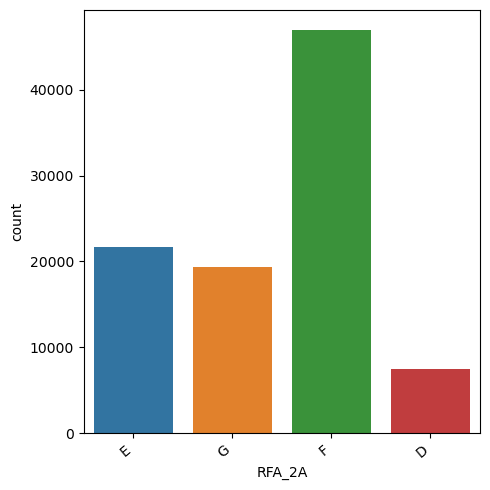

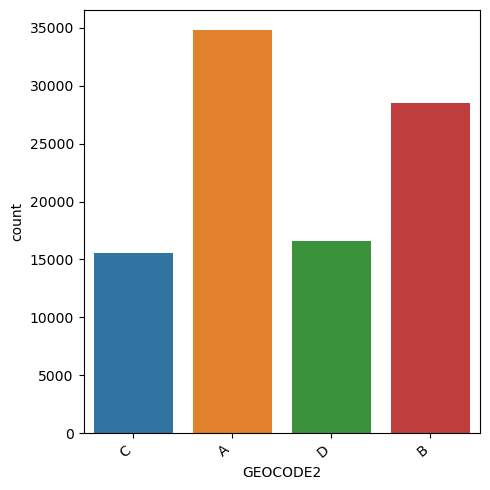

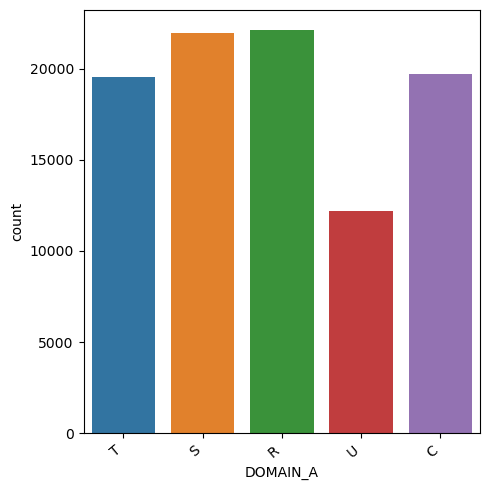

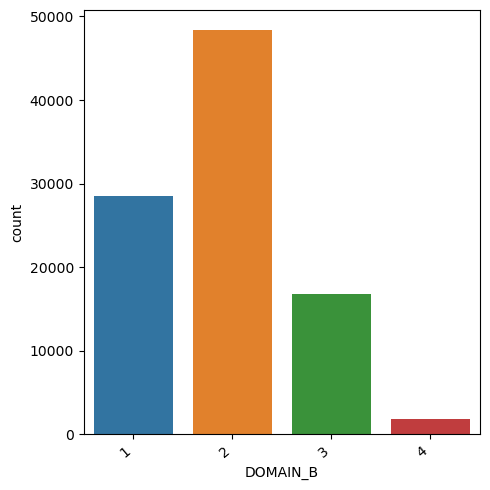

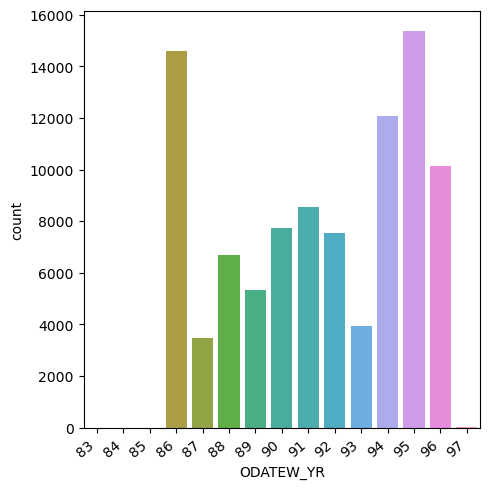

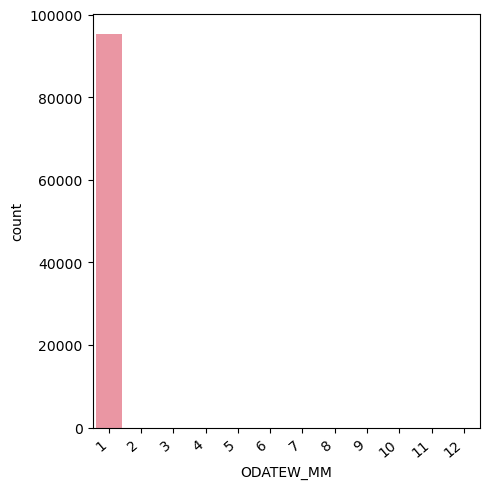

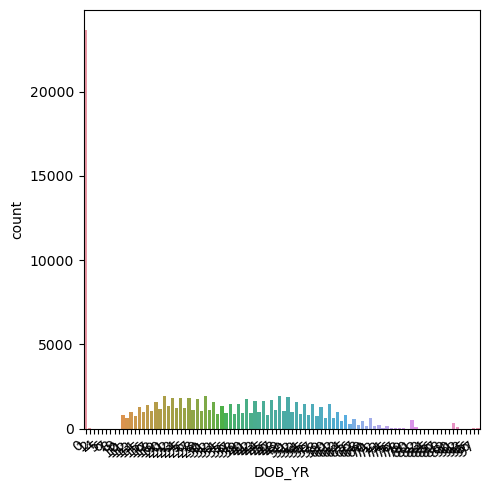

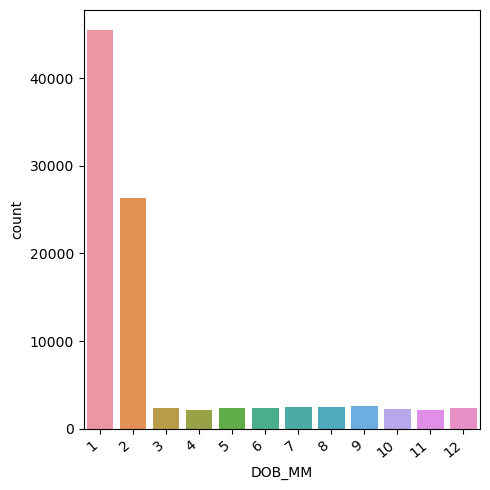

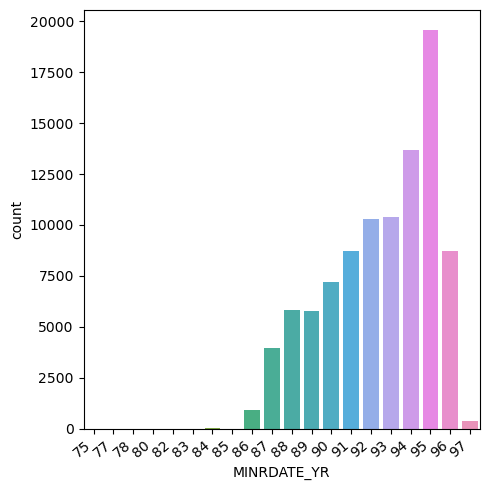

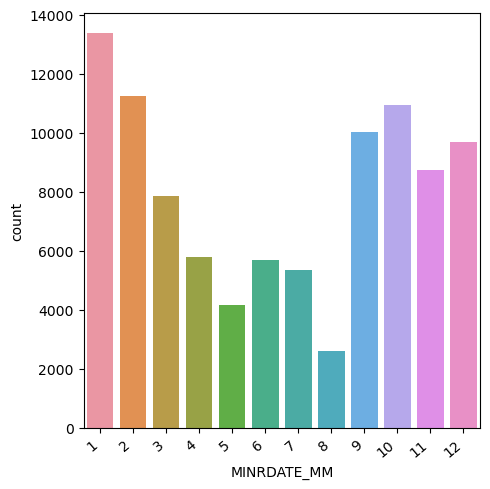

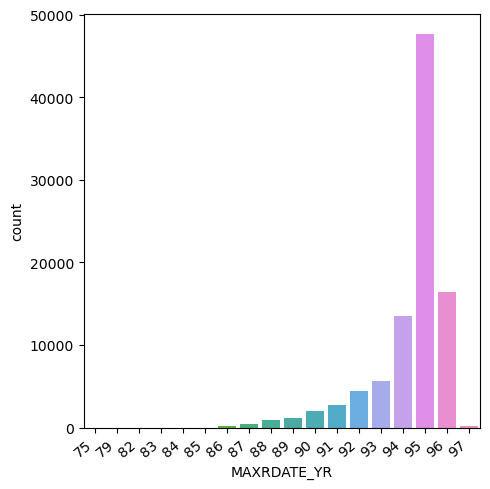

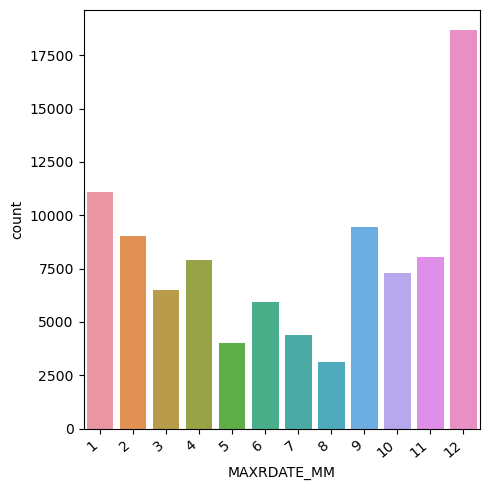

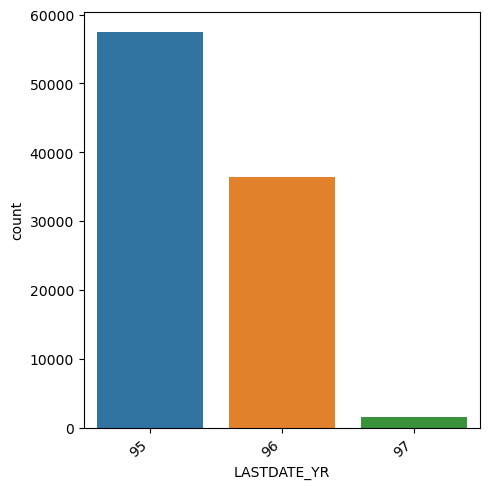

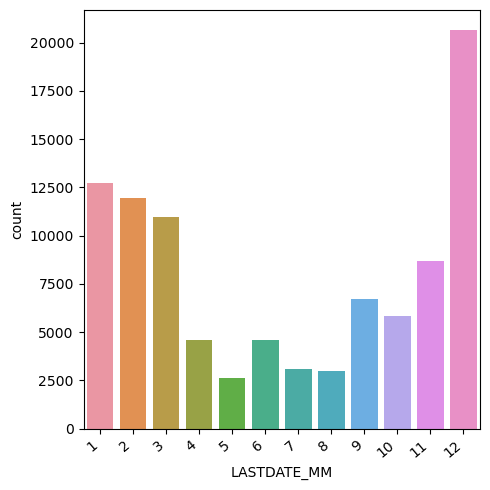

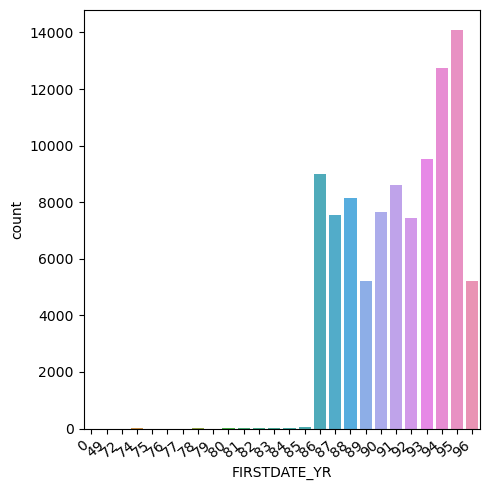

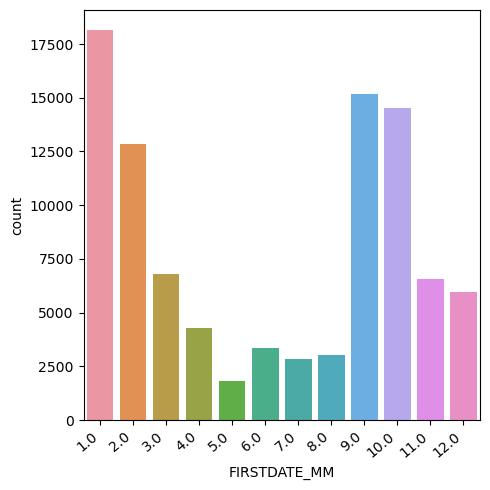

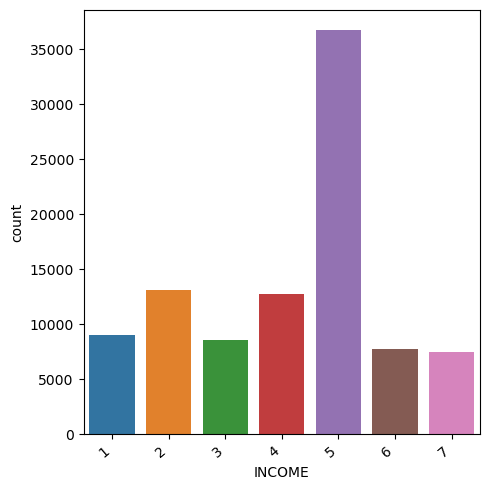

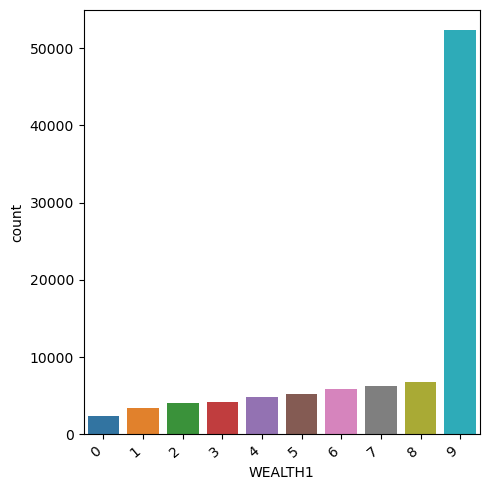

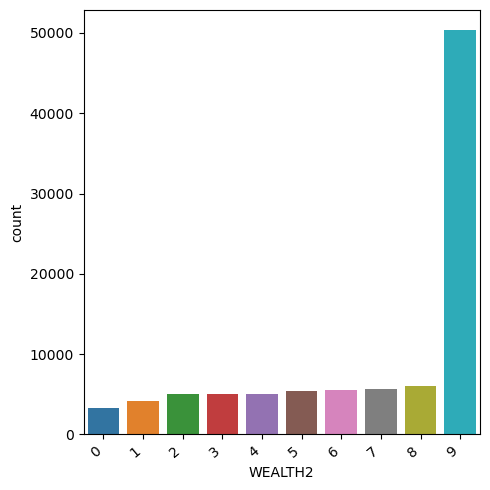

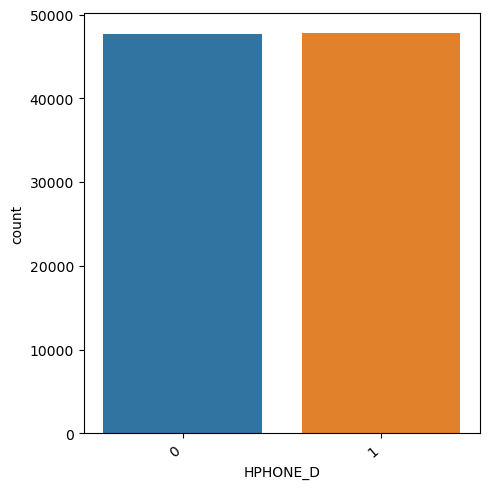

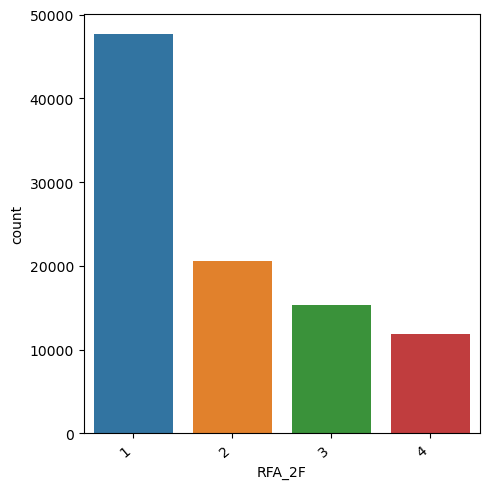

In [307]:
plot_categorical_countplot(categorical)

From the plots and the categorical summary table:

RFA_2R: Recency code for RFA_2 --> likely to drop --> only one unique value!
ODATEW_YR, ODATEW_MM: Date of donor's first gift to PVA YYMM format (Year/Month). --> drop!  
DOB_YR, DOB_MM: Date of birth, we already have that info in "Age" --> drop!  
MINRDATE_YR, MINRDATE_MM: Date associated with the smallest gift to date  --> keep for now  
MAXRDATE_YR, MAXRDATE_MM: Date associated with the largest gift to date  --> keep for now  
LASTDATE_YR, LASTDATE_MM: Date associated with the most recent gift   --> keep for now  
FIRSTDATE_YR, FIRSTDATE_MM: Date of first gift, --> assumption that there is no influence drop! 
WEALTH1, WEALTH2: WEALTH1/2 Wealth Rating, They look quite similar --> drop WEALTH1

WEALTH2 Wealth Rating
Wealth rating uses median family income and
population statistics from each area to
index relative wealth within each state
The segments are denoted 0-9, with 9 being
the highest income group and zero being the
lowest. Each rating has a different meaning
within each state.

HPHONE_D: Indicator for presence of a published home
phone number

From description:
- Drop DATASRCE: assumption no influence on target
- 

In [308]:
categorical_to_drop = ['RFA_2R', 'ODATEW_YR', 'ODATEW_MM', 'DOB_YR', 'DOB_MM', 
'FIRSTDATE_YR','FIRSTDATE_MM', 'MINRDATE_YR', 'MINRDATE_MM','MAXRDATE_YR','MAXRDATE_MM', 'DATASRCE', 'GEOCODE2','WEALTH1']

In [309]:
categorical = categorical.drop(columns=categorical_to_drop)

In [310]:
categorical.head()

,STATE,CLUSTER,HOMEOWNR,GENDER,RFA_2A,DOMAIN_A,DOMAIN_B,LASTDATE_YR,LASTDATE_MM,INCOME,WEALTH2,HPHONE_D,RFA_2F
0,IL,36,H,F,E,T,2,95,12,5,5,0,4
1,CA,14,H,M,G,S,1,95,12,6,9,0,2
2,NC,43,U,M,E,R,2,95,12,3,1,1,4
3,CA,44,U,F,E,R,2,95,12,1,0,1,4
4,FL,16,H,F,F,S,2,96,1,3,9,1,2


In [311]:
get_percentnan(categorical)

,column_name,nulls_percentage


In [312]:
categorical.shape

(95412, 13)

In [313]:
categorical.dtypes

STATE          object
CLUSTER         int64
HOMEOWNR       object
GENDER         object
RFA_2A         object
DOMAIN_A       object
DOMAIN_B        int64
LASTDATE_YR     int64
LASTDATE_MM     int64
INCOME         object
WEALTH2        object
HPHONE_D       object
RFA_2F         object
dtype: object

In [314]:
#Change CLUSTER,DOMAIN_B, LASTDATE_YR, LASTDATE_MM to object:
categorical = categorical.applymap(str)

### Numerical Columns

In [315]:
print(numerical.shape)
numerical.head()

(95412, 310)


,TCODE,AGE,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,CLUSTER2
0,0,60.000000,0,0,39,34,18,10,2,1,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,27,74,6,14,240.0,31,14,5.0,12.0,10.0,4,7.741935,95515,39
1,1,46.000000,16,0,15,55,11,6,2,1,3611,940,998,99,0,0,50,50,67,0,0,31,6,4,2,6,4,14,0,0,2,0,1,4,34,41,43,32,42,45,32,33,46,21,13,14,33,23,10,4,2,11,16,36,22,15,12,1,5,4,21,75,55,23,9,69,4,3,24,317,360,99,99,0,0,0,0,0,0,0,5468,5218,12,10,96,4,97,3,9,59,94,88,55,95,5,4,1,3,5,4,2,18,44,5,0,0,0,97,98,98,98,99,94,0,83,76,73,21,5,0,0,0,4,0,0,0,91,91,91,94,4480.0,13.0,803.0,1088,1096,1026,1037,36175,2,6,2,5,15,14,13,10,33,2,5,2,5,15,14,14,10,32,6,2,66,3,56,44,9,80,14,0,0,0,0,0,0,6,0,2,24,32,12,71,70,83,58,81,57,64,57,99,99,0,22,24,4,21,13,2,1,6,0,4,1,0,3,1,0,6,13,1,2,8,18,11,4,3,4,10,7,11,1,6,2,1,16,69,5,2,160,5,5,12,21,7,30,20,14,24,4,24,10,0,0,0,8,15,0,55,10,11,0,0,2,0,3,1,1,2,3,1,1,0,3,0,0,0,42,39,50,7,27,16,99,92,53,5,10,2,26,56,97,99,0,0,0,96,0,4,0,0,0,99,0,99,99,99,20,4,6,5,12,32,6,13,47.0,3,1,10.0,25.0,25.0,18,15.666667,148535,1
2,1,61.611649,2,0,20,29,33,6,8,1,7001,2040,2669,0,2,98,49,51,96,2,0,0,2,0,0,0,0,0,0,0,2,0,0,0,35,43,46,37,45,49,23,35,40,25,13,20,19,16,13,10,8,15,14,30,22,19,25,10,23,21,35,44,22,6,2,63,9,9,19,183,254,69,69,1,6,5,3,3,3,0,497,546,2,1,78,22,93,7,18,36,76,65,30,86,14,7,2,5,11,17,3,17,60,18,0,1,0,0,1,6,18,50,0,4,36,49,51,14,5,4,2,24,11,2,3,6,0,2,9,44,0.0,281.0,518.0,251,292,292,340,11576,32,18,20,15,12,2,0,0,1,20,19,24,18,16,2,0,0,1,28,8,31,11,38,62,8,74,22,0,0,0,0,0,2,2,1,21,19,24,6,61,65,73,59,70,56,78,62,82,99,4,10,5,2,6,12,0,1,9,5,18,20,5,7,6,0,11,33,4,3,2,12,3,3,2,0,7,8,3,3,6,7,1,8,74,3,1,120,22,20,28,16,6,5,3,1,23,1,16,6,0,0

In [316]:
get_percentnan(numerical)

,column_name,nulls_percentage


In [317]:
data_colandtype(numerical)

,header_name,row_0,type,#_unique_values
0,TCODE,0.000000,int64,55
1,AGE,60.000000,float64,97
2,HIT,0.000000,int64,75
3,MALEMILI,0.000000,int64,95
4,MALEVET,39.000000,int64,89
5,VIETVETS,34.000000,int64,95
6,WWIIVETS,18.000000,int64,100
7,LOCALGOV,10.000000,int64,55
8,STATEGOV,2.000000,int64,65
9,FEDGOV,1.000000,int64,55


We have a lot of columns that are numerical: 310. So we apply the KBest function to get the 30 best variables.

In [318]:
# Same scale for all the variables - MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical_scaled = scaler.fit_transform(numerical)


#### KBest

In [319]:
X = numerical_scaled
y = target['TARGET_B']

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# KBest selects the best 30 columns from the chi2 test.
kbest = SelectKBest(chi2, k=30).fit_transform(X, y)
kbest

selected = pd.DataFrame(kbest)
selected.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.010101,0.079833,0.105833,0.230769,0.153846,0.000000,0.000000,0.020202,0.070707,0.131313,0.272727,0.474747,0.000000,0.020202,0.050505,0.171717,0.000000,0.010101,0.040404,0.020202,0.515152,0.010101,0.747475,0.313131,0.433333,0.366492,0.127119,0.341463,0.498045,0.622951
1,0.000000,0.911333,0.869667,0.923077,0.769231,0.000000,0.000000,0.979798,0.989899,0.989899,0.989899,1.000000,0.949495,0.919192,0.919192,0.919192,0.478632,0.333333,0.020202,0.323232,0.666667,0.030303,0.393939,0.979798,0.183333,0.146597,0.008475,0.024390,0.774510,0.000000
2,0.020202,0.082833,0.091000,0.153846,0.076923,0.000000,0.010101,0.000000,0.010101,0.060606,0.181818,0.505051,0.000000,0.000000,0.020202,0.090909,0.000000,0.010101,0.202020,0.010101,0.313131,0.111111,0.848485,0.505051,0.416667,0.308901,0.110169,0.341463,0.078617,0.967213
3,0.000000,0.166667,0.210500,0.153846,0.076923,0.000000,0.000000,0.101010,0.252525,0.505051,0.696970,0.929293,0.101010,0.010101,0.080808,0.171717,0.997863,0.040404,0.353535,0.050505,0.262626,0.202020,0.676768,0.393939,0.433333,0.324607,0.063559,0.170732,0.899764,0.655738
4,0.989899,0.096000,0.099000,0.307692,0.230769,0.381818,0.585859,0.000000,0.010101,0.020202,0.161616,0.676768,0.000000,0.252525,0.585859,0.747475,0.534188,0.020202,0.212121,0.030303,0.111111,0.141414,0.656566,0.060606,0.700000,0.570681,0.152542,0.195122,0.037079,0.409836


In [320]:
# To check the scores
# model based on the 30 best columns
kbest = SelectKBest(chi2, k=30).fit(X, y) 
#we do not do the transform, because we are interested in the scores information of the fitting step.
df = pd.DataFrame(data = kbest.scores_, columns = ['score'])
df['Column'] = numerical.columns
print(df.sort_values(by = ['score'], ascending = False).head(30))

         score    Column
302  27.516508  CARDGIFT
107  26.474583      HVP1
108  25.757492      HVP2
109  21.545080      HVP3
112  19.261394      HVP6
110  14.874056      HVP4
19   13.034181      ETH2
126  12.581538       RP1
127  11.022637       RP2
301   8.909015  NGIFTALL
80    8.309269       HV1
81    8.260178       HV2
105   7.470098     ETHC5
104   7.224822     ETHC4
296   7.083556  CARDPROM
297   6.744744   NUMPROM
128   5.622626       RP3
111   5.545304      HVP5
309   4.838850  CLUSTER2
83    3.847846       HV4
82    3.772977       HV3
147   2.894568      IC15
130   2.873016       MSA
155   2.838548      IC23
308   2.751733  CONTROLN
159   2.713679     HHAS4
158   2.675815     HHAS3
276   2.508204       HC6
263   2.472344     POBC2
146   2.434518      IC14


In [321]:
cols_kbest = df.sort_values(by = ['score'], ascending = False).head(30)['Column']
list(cols_kbest)

['CARDGIFT',
 'HVP1',
 'HVP2',
 'HVP3',
 'HVP6',
 'HVP4',
 'ETH2',
 'RP1',
 'RP2',
 'NGIFTALL',
 'HV1',
 'HV2',
 'ETHC5',
 'ETHC4',
 'CARDPROM',
 'NUMPROM',
 'RP3',
 'HVP5',
 'CLUSTER2',
 'HV4',
 'HV3',
 'IC15',
 'MSA',
 'IC23',
 'CONTROLN',
 'HHAS4',
 'HHAS3',
 'HC6',
 'POBC2',
 'IC14']

In [322]:
# 30 variables
numerical_Kbest = numerical[['CARDGIFT',
 'HVP1',
 'HVP2',
 'HVP3',
 'HVP6',
 'HVP4',
 'ETH2',
 'RP1',
 'RP2',
 'NGIFTALL',
 'HV1',
 'HV2',
 'ETHC5',
 'ETHC4',
 'CARDPROM',
 'NUMPROM',
 'RP3',
 'HVP5',
 'CLUSTER2',
 'HV4',
 'HV3',
 'IC15',
 'MSA',
 'IC23',
 'CONTROLN',
 'HHAS4',
 'HHAS3',
 'HC6',
 'POBC2',
 'IC14']]

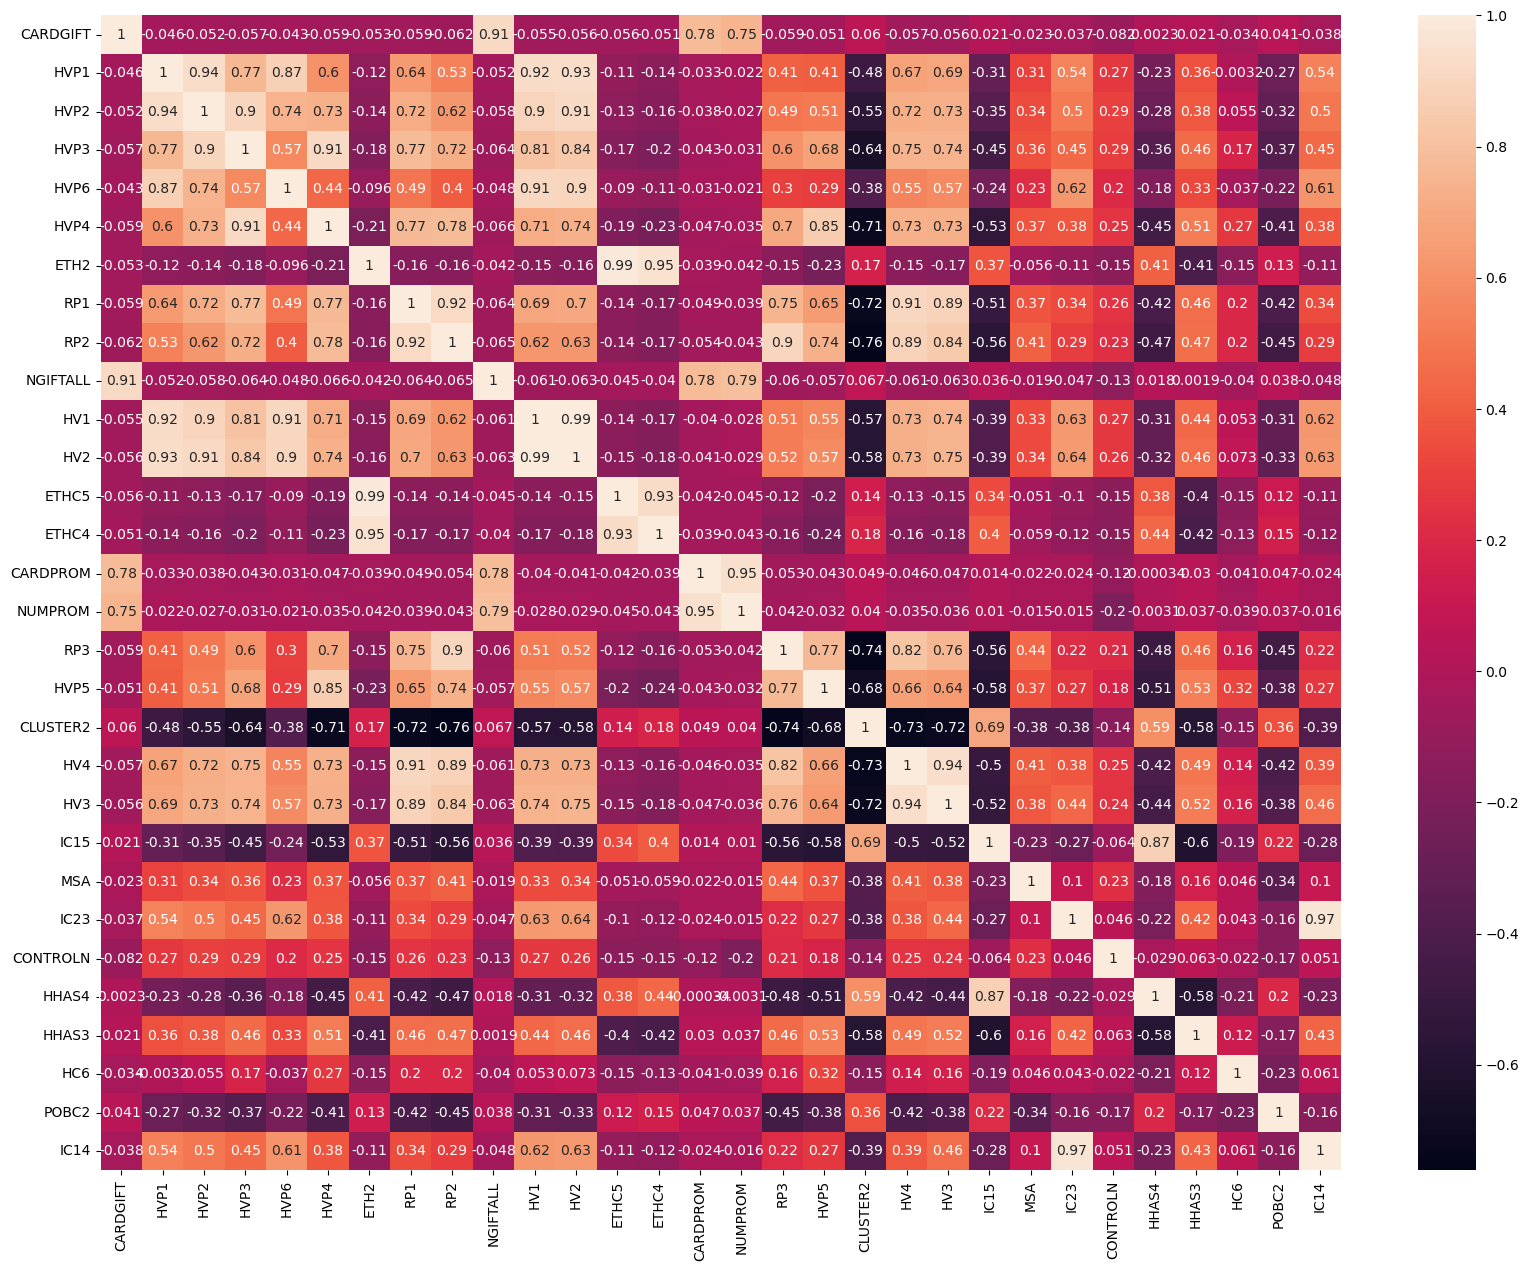

In [323]:
corr_matrix = numerical_Kbest.corr(method='pearson')
fig, ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()


ETH: 
Get rid of ETHC1-6 --> they combine Age and Ethnicity  
Get rid of ETH2 --> information about Ethnicity (high collinearity), but only black the other ones are not 

We drop all the HVPs and the RPs, HV1 and HV3, because of high collinearity and because the information they give is similar.: 
HVP: Percent Home Value  
RP: Percent Renters Paying  
HV1 Median Home Value in hundreds  
HV2 Average Home Value in hundreds  
HV3 Median Contract Rent in hundreds  
HV4 Average Contract Rent in hundreds  

CARDPROM Lifetime number of card promotions received to
date.
NUMPROM Lifetime number of promotions received to date
--> keep NUMPROM

CLUSTER2 Classic Cluster Code --> keep
INCOME HOUSEHOLD INCOME --> drop
IC15, IC23, HHAS3, HHAS4

HC6 Percent Owner Occupied Structures Built Since 1970.

POBC2 Percent Born in State of Residence

In [324]:
def getcollinearity(corr_matrix, column_to_check):
    collinearity = corr_matrix[(corr_matrix[column_to_check] >= 0)]
    collinearity = collinearity[column_to_check]
    return collinearity

In [325]:
getcollinearity(corr_matrix,'HHAS4')

CARDGIFT    0.002290
ETH2        0.413315
NGIFTALL    0.017626
ETHC5       0.381487
ETHC4       0.440693
CLUSTER2    0.589413
IC15        0.873561
HHAS4       1.000000
POBC2       0.196017
Name: HHAS4, dtype: float64

In [326]:
numerical_drop = ['ETH2','ETHC5','ETHC4','HVP1', 'HVP2', 'HVP3', 'HVP4', 
'HVP5', 'HVP6','RP1', 'RP2','RP3','HV1','HV3', 'CARDPROM',
'IC15','IC23', 'HHAS4','HHAS3', 'CONTROLN']

numerical_keep = ['RFA_2F', 'CARDGIFT', 'NGIFTALL', 'NUMPROM', 'CLUSTER2', 'INCOME',
'MSA','HV2','HV4','HC6','POBC2', 'IC1']

In [327]:
numerical_selected = numerical.filter(numerical_keep)
display(numerical_selected.shape)
numerical_selected.head()

(95412, 10)

,CARDGIFT,NGIFTALL,NUMPROM,CLUSTER2,MSA,HV2,HV4,HC6,POBC2,IC1
0,14,31,74,39,0.0,635,2,31,74,307
1,1,3,32,1,4480.0,5218,10,97,39,1088
2,14,27,63,60,0.0,546,1,50,84,251
3,7,16,66,41,9340.0,1263,1,39,67,386
4,8,37,113,26,5000.0,594,3,6,65,240


## Processing Data

### Concatenate Data

In [328]:
data = pd.concat([categorical, numerical_selected], axis = 1)

In [329]:
y = target['TARGET_B']
X = data

In [330]:
# We do the Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [331]:
display(X_train.shape)
X_train.head()

(76329, 23)

,STATE,CLUSTER,HOMEOWNR,GENDER,RFA_2A,DOMAIN_A,DOMAIN_B,LASTDATE_YR,LASTDATE_MM,INCOME,WEALTH2,HPHONE_D,RFA_2F,CARDGIFT,NGIFTALL,NUMPROM,CLUSTER2,MSA,HV2,HV4,HC6,POBC2,IC1
85225,IL,2,H,F,F,U,1,96,2,5,9,1,1,1,1,13,27,1600.0,1356,5,7,57,321
70004,TX,11,H,F,F,S,1,95,9,4,9,0,2,7,11,64,59,0.0,669,2,65,64,197
88133,other,36,H,M,E,T,2,96,1,7,9,1,2,13,16,64,53,0.0,454,2,44,86,230
79106,other,21,H,M,E,S,3,95,6,2,5,1,1,9,18,66,22,5120.0,763,4,29,86,354
35476,other,43,U,F,F,R,2,95,12,1,2,1,1,6,7,55,43,4120.0,714,3,75,17,270


In [332]:
#splitting into categorical and numerical
X_train_num = X_train.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = object)

X_test_num = X_test.select_dtypes(include = np.number)
X_test_cat = X_test.select_dtypes(include = object)

In [333]:
display(X_train_num.shape)
X_train_num.head()
#display(X_train_cat.shape)

(76329, 10)

,CARDGIFT,NGIFTALL,NUMPROM,CLUSTER2,MSA,HV2,HV4,HC6,POBC2,IC1
85225,1,1,13,27,1600.0,1356,5,7,57,321
70004,7,11,64,59,0.0,669,2,65,64,197
88133,13,16,64,53,0.0,454,2,44,86,230
79106,9,18,66,22,5120.0,763,4,29,86,354
35476,6,7,55,43,4120.0,714,3,75,17,270


In [334]:
#Transformation on numericals:
# Normalizing data: make data range from 0 - 1, instead of from min to max
transformer = MinMaxScaler().fit(X_train_num)
numericals_train_scaled = transformer.transform(X_train_num)
numericals_train_scaled = pd.DataFrame(numericals_train_scaled, columns=X_train_num.columns)

numericals_test_scaled = transformer.transform(X_test_num)
numericals_test_scaled = pd.DataFrame(numericals_test_scaled, columns=X_test_num.columns)

### Ordinal Encoding:

- Income, 
- Wealth2, 
- Domain_B

In [335]:
# # Ordinal Encoding
ordinal_train = X_train_cat[['INCOME', 'WEALTH2', 'DOMAIN_B']]
ordinal_test = X_test_cat[['INCOME', 'WEALTH2', 'DOMAIN_B']]
ordinal_train.head()

,INCOME,WEALTH2,DOMAIN_B
85225,5,9,1
70004,4,9,1
88133,7,9,2
79106,2,5,3
35476,1,2,2


### ONEHOT Encoding

In [336]:
onehot_train= X_train_cat.drop(['INCOME', 'WEALTH2', 'DOMAIN_B'], axis = 1)
onehot_test= X_test_cat.drop(['INCOME', 'WEALTH2', 'DOMAIN_B'], axis = 1)
onehot_train.head()

,STATE,CLUSTER,HOMEOWNR,GENDER,RFA_2A,DOMAIN_A,LASTDATE_YR,LASTDATE_MM,HPHONE_D,RFA_2F
85225,IL,2,H,F,F,U,96,2,1,1
70004,TX,11,H,F,F,S,95,9,0,2
88133,other,36,H,M,E,T,96,1,1,2
79106,other,21,H,M,E,S,95,6,1,1
35476,other,43,U,F,F,R,95,12,1,1


In [337]:
# ONEHOT Encoding:
encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(onehot_train)

categoricals_train_encoded = encoder.transform(onehot_train).toarray()
categoricals_test_encoded = encoder.transform(onehot_test).toarray()

In [338]:
# Combine train and test-data
X_train_processed = np.concatenate((ordinal_train, categoricals_train_encoded, numericals_train_scaled),axis=1)
X_test_processed = np.concatenate((ordinal_test, categoricals_test_encoded, numericals_test_scaled),axis=1)

### Modeling

In [339]:
from sklearn.linear_model import LogisticRegression

# fit the model on the data training set
LR = LogisticRegression(random_state=0, solver='lbfgs')
LR.fit(X_train_processed, y_train)
R2_score = LR.score(X_test_processed, y_test)
R2_score

/Users/josephinebonvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9487501965099827

In [340]:
y_predicted_train = LR.predict(X_test_processed)
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test,y_predicted_train)
conf_matrix

array([[18105,     0],
       [  978,     0]])

In [341]:
# predicted         | False | True  |
# -----------------------------------
# actual  False     |   +   |       |
# -----------------------------------
#         True      |       |   +   |

Even though we have a very high R2-Score, the results of the confusion matrix show that we are not able to predict
the people who are donating correctly. This is due to imbalance

## Managing imbalance in the dataset
- only on training set of the data

In [342]:
type(X_train_processed)

numpy.ndarray

In [343]:
X_train_imb = pd.DataFrame(X_train_processed)
X_train_imb.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102
0,5,9,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.027778,0.0,0.04712,0.42623,0.17094,0.226,0.384615,0.070707,0.575758,0.214
1,4,9,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.194444,0.042373,0.314136,0.95082,0.0,0.1115,0.153846,0.656566,0.646465,0.131333
2,7,9,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.361111,0.063559,0.314136,0.852459,0.0,0.075667,0.153846,0.444444,0.868687,0.153333
3,2,5,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.25,0.072034,0.324607,0.344262,0.547009,0.127167,0.307692,0.292929,0.868687,0.236
4,1,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.025424,0.267016,0.688525,0.440171,0.119,0.230769,0.757576,0.171717,0.18


In [344]:
y_train = pd.DataFrame(y_train)
y_train.value_counts()
y_train.head()

,TARGET_B
85225,0
70004,0
88133,0
79106,0
35476,0


In [345]:
# we need to reset the index for the concatenation otherwise
y_train = y_train.reset_index(drop=True)


In [346]:
trainset = pd.concat((X_train_imb, y_train), axis = 1)
trainset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,TARGET_B
0,5,9,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.027778,0.0,0.04712,0.42623,0.17094,0.226,0.384615,0.070707,0.575758,0.214,0
1,4,9,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.194444,0.042373,0.314136,0.95082,0.0,0.1115,0.153846,0.656566,0.646465,0.131333,0
2,7,9,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.361111,0.063559,0.314136,0.852459,0.0,0.075667,0.153846,0.444444,0.868687,0.153333,0
3,2,5,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.25,0.072034,0.324607,0.344262,0.547009,0.127167,0.307692,0.292929,0.868687,0.236,0
4,1,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.166667,0.025424,0.267016,0.688525,0.440171,0.119,0.230769,0.757576,0.171717,0.18,0


In [347]:
get_percentnan(trainset)

,column_name,nulls_percentage


In [348]:
from sklearn.utils import resample

category_0 = trainset[trainset['TARGET_B'] == 0]
category_1 = trainset[trainset['TARGET_B'] == 1]

### Downsampling (undersampling)

In [349]:
category_0_undersampled = resample(category_0, 
                                   replace=False, 
                                   n_samples = len(category_1))

In [350]:
print(category_0_undersampled.shape)
print(category_1.shape)

(3865, 104)
(3865, 104)


In [351]:
data_downsampled = pd.concat([category_0_undersampled, category_1], axis=0)

In [352]:
data_downsampled['TARGET_B'].value_counts()

0    3865
1    3865
Name: TARGET_B, dtype: int64

### Modelling with downsampling

In [353]:
y_train_down = data_downsampled['TARGET_B']
X_train_down = data_downsampled.drop(['TARGET_B'], axis = 1)

In [354]:
# fit the model on the data training set
LR_down = LogisticRegression(random_state=0, solver='lbfgs')
LR_down.fit(X_train_down, y_train_down)
R2_down = LR_down.score(X_test_processed, y_test)
R2_down


/Users/josephinebonvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5889011161767018

In [355]:
y_train_down = LR_down.predict(X_test_processed)
from sklearn.metrics import confusion_matrix
conf_matrix_down = confusion_matrix(y_test,y_train_down)
conf_matrix_down

array([[10689,  7416],
       [  429,   549]])

In [356]:
# predicted         | False | True  |
# -----------------------------------
# actual  False     |   +   |       |
# -----------------------------------
#         True      |       |   +   |

### Upsampling (oversampling)

In [357]:
category_1_oversampled = resample(category_1, 
                                  replace=True, 
                                  n_samples = len(category_0))

In [358]:
print(category_0.shape)
print(category_1_oversampled.shape)

(72464, 104)
(72464, 104)


In [359]:
data_upsampled = pd.concat([category_0, category_1_oversampled], axis=0)

In [360]:
data_upsampled['TARGET_B'].value_counts()

0    72464
1    72464
Name: TARGET_B, dtype: int64

### Modelling with upsampling

In [361]:
y_train_up = data_upsampled['TARGET_B']
X_train_up = data_upsampled.drop(['TARGET_B'], axis = 1)

In [362]:
# fit the model on the data training set
LR_up = LogisticRegression(random_state=0, solver='lbfgs')
LR_up.fit(X_train_up, y_train_up)
R2_up = LR_up.score(X_test_processed, y_test)
R2_up

/Users/josephinebonvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.607661269192475

In [363]:
y_train_up = LR_up.predict(X_test_processed)
from sklearn.metrics import confusion_matrix
conf_matrix_up = confusion_matrix(y_test,y_train_up)
conf_matrix_up

array([[11043,  7062],
       [  425,   553]])

In [364]:
# predicted         | False | True  |
# -----------------------------------
# actual  False     |   +   |       |
# -----------------------------------
#         True      |       |   +   |

## Conclusion

In [368]:
print('Score imbalanced data:', R2_score,'\nScore downsampled balanced data:', R2_down,'\nScore upsampled balanced data:', R2_up)

R2 imbalanced data: 0.9487501965099827 
R2 downsampled balanced data: 0.5889011161767018 
R2 upsampled balanced data: 0.607661269192475


In [371]:
print('imbalanced data:\n', conf_matrix,'\ndownsampled balanced data:\n', conf_matrix_down,'\nupsampled balanced data:\n', conf_matrix_up)

imbalanced data:
 [[18105     0]
 [  978     0]] 
downsampled balanced data:
 [[10689  7416]
 [  429   549]] 
upsampled balanced data:
 [[11043  7062]
 [  425   553]]


In [ ]:
# predicted         | False | True  |
# -----------------------------------
# actual  False     |   +   |       |
# -----------------------------------
#         True      |       |   +   |

We can see that our score has gotten worse with the balanced data. The confusion matrix shows, that the predicting of donors has improved on the other hand. with the upsampled data, we have slightly more True <> True combinations and less predicted False <> actual True.  

In a next step we could go back to our model and recheck some features